In [17]:
import sys
sys.path.append('../')

%reload_ext autoreload
%autoreload 2

import Utility as ut
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

import plotly.express as px
import pylab as pl

from matplotlib.lines import Line2D

from collections import Counter

np.random.seed(0)

In [18]:
cycleY = pd.read_csv("../Data/Chickens data/WithMacro/CycleY-Clean.csv")
cycleZ = pd.read_csv("../Data/Chickens data/WithMacro/CycleZ-Clean.csv")
cycleA = pd.read_csv("../Data/Chickens data/WithMacro/CycleA-Clean.csv")
cycleB = pd.read_csv("../Data/Chickens data/WithMacro/CycleB-Clean.csv")
cycleX1 = pd.read_csv("../Data/Chickens data/WithMacro/CycleX_1-Clean.csv")
cycleX2 = pd.read_csv("../Data/Chickens data/WithMacro/CycleX_2-Clean.csv")

cycleY = cycleY.rename(columns={"Laied": "Laid"})
cycleZ = cycleZ.rename(columns={"Laied": "Laid"})
cycleA = cycleA.rename(columns={"Laied": "Laid"})
cycleB = cycleB.rename(columns={"Laied": "Laid"})
cycleX1 = cycleX1.rename(columns={"Laied": "Laid"})
cycleX2 = cycleX2.rename(columns={"Laied": "Laid"})

In [19]:
cycleX = pd.concat([cycleX1,cycleX2], axis=0, ignore_index=True)

In [20]:
parameters = ["DeathPerc" , "Laid", "AvgTemp", "AvgHum"]

In [21]:
meansA = []
meansB = []
meansZ = []
meansY = []
meansX = []
#meansX1 = []
#meansX2 = []
for p in parameters:
    if p == "DeathPerc" or p == "Laid":
        meansA.append(cycleA[p].mean()*100)
        meansB.append(cycleB[p].mean()*100)
        meansZ.append(cycleZ[p].mean()*100)
        meansY.append(cycleY[p].mean()*100)
        meansX.append(cycleX[p].mean()*100)

        #meansX1.append(cycleX1[p].mean()*100)
        #meansX2.append(cycleX2[p].mean()*100)
    else:
        meansA.append(cycleA[p].mean())
        meansB.append(cycleB[p].mean())
        meansZ.append(cycleZ[p].mean())
        meansX.append(cycleX[p].mean())
        #meansX1.append(cycleX1[p].mean())
        #meansX2.append(cycleX2[p].mean())
        meansY.append(cycleY[p].mean())


means = [meansY, meansZ, meansA, meansB, meansX]

In [22]:
ranges = []

for i in range(len(parameters)):
    min = means[0][i]
    max = means[0][i]
    for m in means:
        if m[i] < min:
            min = m[i]
        if m[i] > max:
            max = m[i]
    ranges.append([min - min/4, max + max/11])

In [23]:
ranges

[[0.016019731410891087, 0.05393905556313993],
 [61.0438511783703, 95.7518472079928],
 [8.860878839590443, 16.013082039911307],
 [54.932252559726955, 81.33292735972162]]

In [24]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, axes,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, label, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw, label=label)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

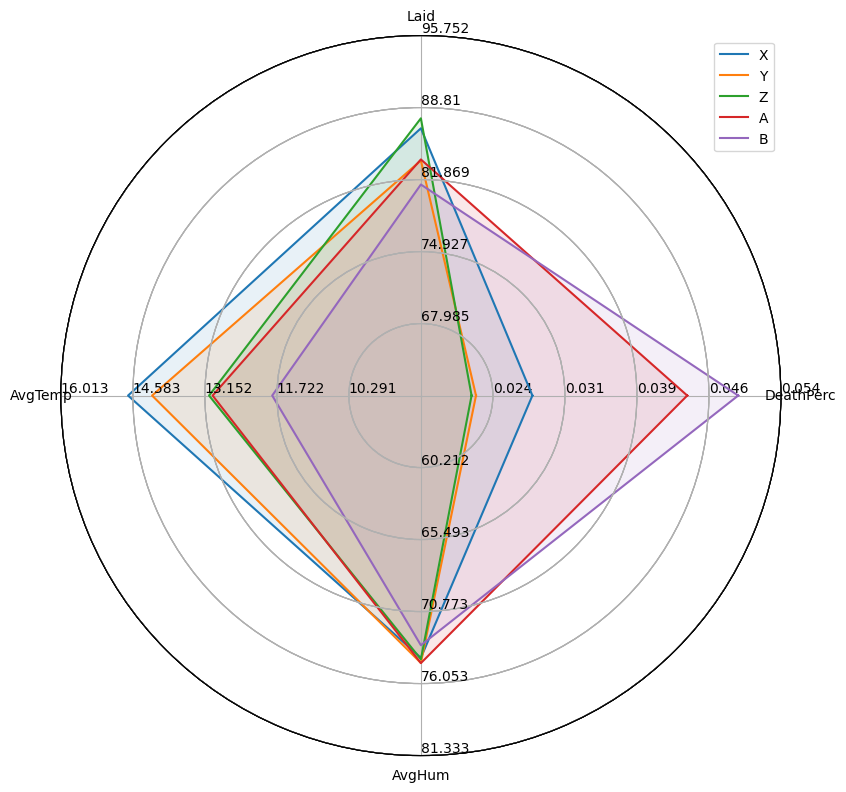

In [25]:
# example data
variables = parameters
ranges = ranges    


# plotting
fig1 = plt.figure(figsize=(8, 8))

axes = [fig1.add_axes([0.1,0.1,0.9,0.9],polar=True,
        label = "axes{}".format(i)) 
        for i in range(len(variables))]

radar5 = ComplexRadar(fig1, variables, ranges, axes)
radar5.plot(meansX, label="X")
radar5.fill(meansX, alpha=0.1)

radar4 = ComplexRadar(fig1, variables, ranges, axes)
radar4.plot(meansY, label="Y")
radar4.fill(meansY, alpha=0.1)

radar3 = ComplexRadar(fig1, variables, ranges, axes)
radar3.plot(meansZ, label="Z")
radar3.fill(meansZ, alpha=0.1)

radar2 = ComplexRadar(fig1, variables, ranges, axes)
radar2.plot(meansA, label="A")
radar2.fill(meansA, alpha=0.1)

radar1 = ComplexRadar(fig1, variables, ranges, axes)
radar1.plot(meansB, label="B")
radar1.fill(meansB, alpha=0.1)

axes[0].legend()

plt.show()   